## Setting up a machine learning environment

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os

import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import mlflow.catboost
from pandas.plotting import table
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier





pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Loading the datasets into dataframes

In [7]:
df_fridayAF_DDos = pd.read_csv("../datasets/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_fridayAF_PortScan = pd.read_csv("../datasets/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_fridayMO = pd.read_csv("../datasets/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_monday = pd.read_csv("../datasets/Monday-WorkingHours.pcap_ISCX.csv")
df_thursdayAF_Infilteration = pd.read_csv("../datasets/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_thursdayMO_WebAttacks = pd.read_csv("../datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_tuesday = pd.read_csv("../datasets/Tuesday-WorkingHours.pcap_ISCX.csv")
df_wednesday = pd.read_csv("../datasets/Wednesday-workingHours.pcap_ISCX.csv")

## Concatenating the dataframes to single dataframe

In [8]:
df_data = pd.concat([df_fridayAF_DDos,df_fridayAF_PortScan,df_fridayMO,df_monday,df_thursdayAF_Infilteration,df_thursdayMO_WebAttacks,df_tuesday,df_wednesday], axis=0,ignore_index=True)

In [9]:
print('Shape after concatenating:', df_data.shape)

Shape after concatenating: (2830743, 79)


In [10]:
print(df_data.columns)

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [11]:
df_data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [12]:
# Displaying unique values from the 'Label' column
unique_attacks = df_data[' Label'].unique()
print(unique_attacks)

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


### Before applying labellization

In [13]:
df_data[' Label'].value_counts()

 Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [14]:
attack_map = {
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DDoS': 'DoS',
    'PortScan': 'PortScan',
    'Bot': 'Bot',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed',
}


In [15]:
df_data[' Label'] = df_data[' Label'].replace(attack_map)

# Now you can print the DataFrame to see the changes
print(df_data[' Label'].unique())


['BENIGN' 'DoS' 'PortScan' 'Bot' 'Infiltration' 'Web Attack' 'Brute Force'
 'Heartbleed']


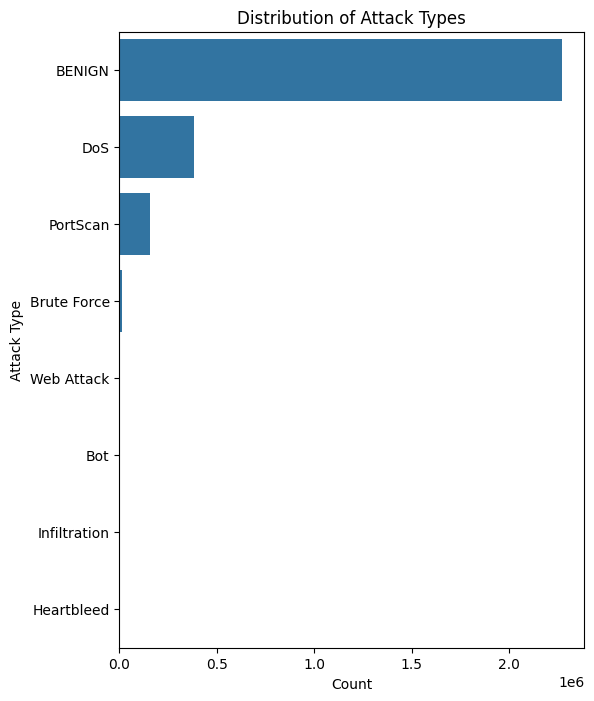

In [16]:

plt.figure(figsize=(6, 8))  # Adjust the size of the plot as needed
sns.countplot(y=' Label', data=df_data, order=df_data[' Label'].value_counts().index)
plt.title('Distribution of Attack Types')
plt.xlabel('Count')
plt.ylabel('Attack Type')
# plt.grid(True)  # Optionally add a grid for better readability
plt.show()


### After applying labellization

In [17]:
label_counts = df_data[' Label'].value_counts()

# Print the counts
print(label_counts)

 Label
BENIGN          2273097
DoS              380688
PortScan         158930
Brute Force       13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


# Data Preprocessing

#### Find columns with zero variance; columns where all values are the same

In [18]:
zero_variance_cols = [col for col in df_data.columns if df_data[col].nunique() == 1]

# Display the columns with zero variance
if zero_variance_cols:
    print(f"Columns with zero variance: {zero_variance_cols}")
else:
    print("No columns with zero variance found.")

Columns with zero variance: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


### A bar chart that visually represents the columns with zero variance:

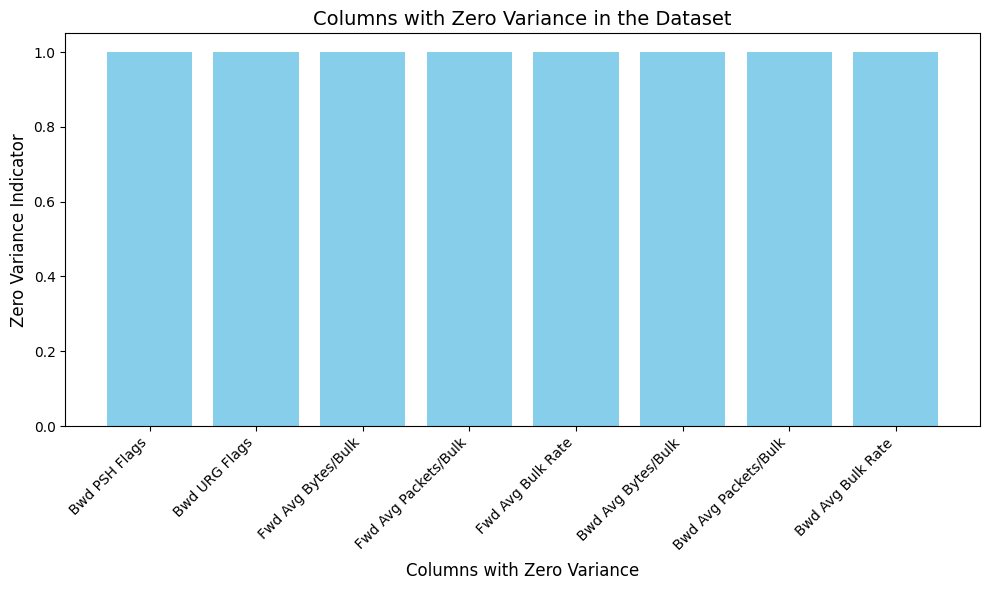

In [19]:
# List of columns with zero variance (as identified in your analysis)
zero_variance_cols = [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']

# Create a figure and axis for the bar plot
plt.figure(figsize=(10, 6))

# Plotting the columns with a fixed height of 1 to represent zero variance
plt.bar(zero_variance_cols, [1] * len(zero_variance_cols), color='skyblue')

# Adding labels and title
plt.xlabel('Columns with Zero Variance', fontsize=12)
plt.ylabel('Zero Variance Indicator', fontsize=12)
plt.title('Columns with Zero Variance in the Dataset', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


##### Shape before removing zero variance columns

In [20]:
print('Shape before removing zero variance columns:', df_data.shape)

Shape before removing zero variance columns: (2830743, 79)


#### Handle columns with zero variance

In [21]:
if zero_variance_cols:
        df_data.drop(zero_variance_cols, axis=1, inplace=True)
        print(f'Dropped zero variance columns: {zero_variance_cols}')

Dropped zero variance columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']


##### Shape after removing zero variance columns

In [22]:
print('Shape after removing zero variance columns:', df_data.shape)

Shape after removing zero variance columns: (2830743, 71)


#### Find  spaces from column names

In [23]:
df_data.keys()

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SYN Flag Count', 

##### Handle spaces from column names

In [24]:
df_data.columns = df_data.columns.str.strip()

In [25]:
df_data.keys()

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

### Identify Rows with NaN, inf, or -inf Values
##### The row listed here contain  NaN ( Not a number) across the columns displayed.

In [26]:
# Select only numeric columns
numeric_cols = df_data.select_dtypes(include=[np.number])

# Check for inf and -inf values in the numeric columns
inf_values = np.isinf(numeric_cols).sum()

# Display the count of inf and -inf values in each numeric column
print("Count of inf and -inf values in each numeric column:")
print(inf_values)

Count of inf and -inf values in each numeric column:
Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1509
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mea

### Check how many NaN it exists

In [27]:
df_data.isna().sum()

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   1358
Flow Packets/s                    0
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

### Replace inf and -inf with Nan

In [28]:
df_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
df_data.isna().sum()

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

In [30]:
print("Check for NaN values in Label column:", df_data['Label'].isna().sum())

Check for NaN values in Label column: 0


In [31]:
df_data['Label'].value_counts()

Label
BENIGN          2273097
DoS              380688
PortScan         158930
Brute Force       13835
Web Attack         2180
Bot                1966
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [32]:
print(df_data.isna().sum())

Destination Port                  0
Flow Duration                     0
Total Fwd Packets                 0
Total Backward Packets            0
Total Length of Fwd Packets       0
Total Length of Bwd Packets       0
Fwd Packet Length Max             0
Fwd Packet Length Min             0
Fwd Packet Length Mean            0
Fwd Packet Length Std             0
Bwd Packet Length Max             0
Bwd Packet Length Min             0
Bwd Packet Length Mean            0
Bwd Packet Length Std             0
Flow Bytes/s                   2867
Flow Packets/s                 2867
Flow IAT Mean                     0
Flow IAT Std                      0
Flow IAT Max                      0
Flow IAT Min                      0
Fwd IAT Total                     0
Fwd IAT Mean                      0
Fwd IAT Std                       0
Fwd IAT Max                       0
Fwd IAT Min                       0
Bwd IAT Total                     0
Bwd IAT Mean                      0
Bwd IAT Std                 

#### This function will filter the dataframe based on NaN values in the specified columns and then calculate the value counts of the 'Label' column for these filtered rows.

In [33]:
def nan_label_counts(df_data, column_nan_list):
    # Create a mask that is True wherever any of the columns in column_nan_list have NaN values
    nan_mask = df_data[column_nan_list].isna().any(axis=1)
    
    # Filter the dataframe based on the NaN mask
    nan_rows = df_data[nan_mask]
    
    # Return the value counts of the 'Label' column in the filtered dataframe
    return nan_rows['Label'].value_counts()

# Example usage:
column_nan_list = ['Flow Bytes/s']
print(nan_label_counts(df_data, column_nan_list))


Label
BENIGN         1777
DoS             951
PortScan        126
Bot              10
Brute Force       3
Name: count, dtype: int64


In [34]:
def nan_label_counts(df_data, column_nan_list):
    # Create a mask that is True wherever any of the columns in column_nan_list have NaN values
    nan_mask = df_data[column_nan_list].isna().any(axis=1)
    
    # Filter the dataframe based on the NaN mask
    nan_rows = df_data[nan_mask]
    
    # Return the value counts of the 'Label' column in the filtered dataframe
    return nan_rows['Label'].value_counts()

# Example usage:
column_nan_list = ['Flow Packets/s']
print(nan_label_counts(df_data, column_nan_list))

Label
BENIGN         1777
DoS             951
PortScan        126
Bot              10
Brute Force       3
Name: count, dtype: int64


#### Since the occurences of Nan are very low, dropping the Nan values will not have any bad effect 

### Ways to handle missing values

##### Drop rows with missing values

In [35]:
df_data.dropna(inplace=True)

In [36]:
df_data.isna().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
Total Length of Bwd Packets    0
Fwd Packet Length Max          0
Fwd Packet Length Min          0
Fwd Packet Length Mean         0
Fwd Packet Length Std          0
Bwd Packet Length Max          0
Bwd Packet Length Min          0
Bwd Packet Length Mean         0
Bwd Packet Length Std          0
Flow Bytes/s                   0
Flow Packets/s                 0
Flow IAT Mean                  0
Flow IAT Std                   0
Flow IAT Max                   0
Flow IAT Min                   0
Fwd IAT Total                  0
Fwd IAT Mean                   0
Fwd IAT Std                    0
Fwd IAT Max                    0
Fwd IAT Min                    0
Bwd IAT Total                  0
Bwd IAT Mean                   0
Bwd IAT Std                    0
Bwd IAT Max                    0
Bwd IAT Min                    0
Fwd PSH Fl

##### Identify duplicate rows

In [37]:
duplicate_rows = df_data[df_data.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows:")
    print(duplicate_rows.shape)
else:
    print("No duplicate rows found.")

Duplicate rows:
(307078, 71)


##### Identify columns with identical values

In [38]:
column_pairs = []
num_columns = len(df_data.columns)

for i in range(num_columns):
    for j in range(i + 1, num_columns):
        if df_data.iloc[:, i].equals(df_data.iloc[:, j]): 
            column_pairs.append((df_data.columns[i], df_data.columns[j]))

In [39]:
print("Shape before removing identical columns:", df_data.shape)

Shape before removing identical columns: (2827876, 71)


####  Print the column pairs with identical values

In [40]:
if column_pairs:
    print("Columns with identical values:")
    for pair in column_pairs:
        print(f"{pair[0]} and {pair[1]} have identical values.")
    
    # Step 3: Drop one column from each pair
    columns_to_drop = [pair[1] for pair in column_pairs]
    df_data.drop(columns=columns_to_drop, axis=1, inplace=True)
    print(f"Dropped columns: {columns_to_drop}")
else:
    print("No columns with identical values found.")

print("Shape after removing identical columns:", df_data.shape)

Columns with identical values:
Total Fwd Packets and Subflow Fwd Packets have identical values.
Total Backward Packets and Subflow Bwd Packets have identical values.
Fwd PSH Flags and SYN Flag Count have identical values.
Fwd URG Flags and CWE Flag Count have identical values.
Fwd Header Length and Fwd Header Length.1 have identical values.
Dropped columns: ['Subflow Fwd Packets', 'Subflow Bwd Packets', 'SYN Flag Count', 'CWE Flag Count', 'Fwd Header Length.1']
Shape after removing identical columns: (2827876, 66)


#### Check for non-numeric columns

In [41]:
non_numeric_columns = df_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['Label'], dtype='object')


#### Displaying the unique categories of cyberattacks from a dataset, represented by the 'Label' column in a DataFrame

In [42]:
print(df_data['Label'].unique())

['BENIGN' 'DoS' 'PortScan' 'Bot' 'Infiltration' 'Web Attack' 'Brute Force'
 'Heartbleed']


### Create a heatmap to visualize missing values

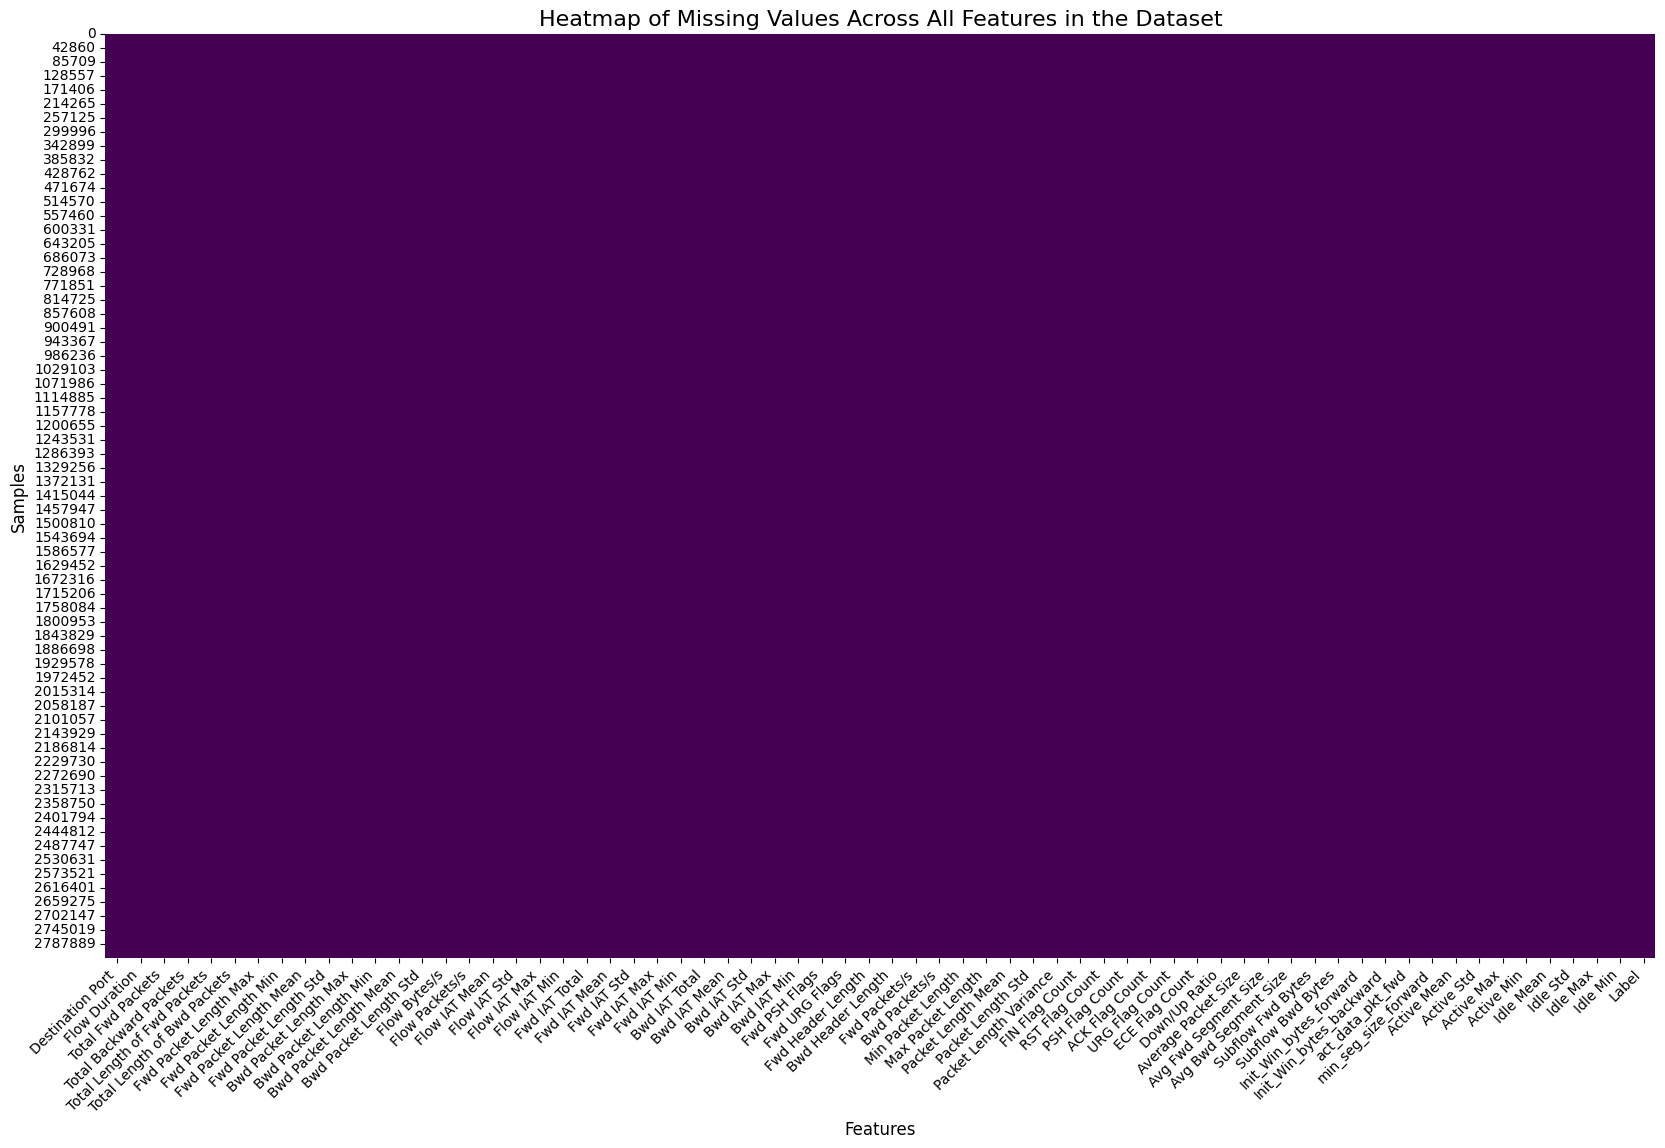

In [43]:
# Increase the size of the figure to accommodate all features
plt.figure(figsize=(20, 12))  # You can adjust the size to fit your dataset

# Plotting the heatmap for all features in the dataset to show missing values
sns.heatmap(df_data.isnull(), cmap='viridis', cbar=False)

# Adding labels and displaying the plot
plt.title('Heatmap of Missing Values Across All Features in the Dataset', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

### Color: The uniform purple color across the entire heatmap indicates consistency in the data regarding the presence or absence of missing values. Since the heatmap shows no variation in color, it tells us that there are no missing (NaN) values in any part of our DataFrame.
### Vertical Axis:  index labels are shown
### Horizontal Axis (X-axis): Displaying the feature of our DataFrame. All columns are represented, and the uniformity of color across all columns confirms that no columns contain missing data.

### Quantitative check to confirm that there are indeed no missing values in the dataset

In [44]:
total_missing = df_data.isnull().sum().sum()
print("Total missing values in the dataset:", total_missing)

Total missing values in the dataset: 0


### Identifying Categorical Features Based on Unique Value Counts

In [45]:
categorical_columns = []

for c in df_data.columns:
    # Check if the column is categorical (dtype of object or category) or numerical with less than 10 unique values
    if df_data[c].nunique() < 10:
        # Print unique values of columns with < 10 unique values
        print(f"Column '{c}' has unique values: {df_data[c].unique()}")
        categorical_columns.append(c)
print("Columns with unique values < 10:")
print(categorical_columns)

Column 'Fwd PSH Flags' has unique values: [0 1]
Column 'Fwd URG Flags' has unique values: [0 1]
Column 'FIN Flag Count' has unique values: [0 1]
Column 'RST Flag Count' has unique values: [0 1]
Column 'PSH Flag Count' has unique values: [0 1]
Column 'ACK Flag Count' has unique values: [1 0]
Column 'URG Flag Count' has unique values: [0 1]
Column 'ECE Flag Count' has unique values: [0 1]
Column 'Label' has unique values: ['BENIGN' 'DoS' 'PortScan' 'Bot' 'Infiltration' 'Web Attack' 'Brute Force'
 'Heartbleed']
Columns with unique values < 10:
['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Label']


### Create numerical columns list and remove the target from categorical columns

#### Categorical columns before removing Label

In [46]:
categorical_columns

['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'ECE Flag Count',
 'Label']

#### Create numerical columns

In [47]:
numerical_columns = [col for col in df_data.columns if col not in categorical_columns]

In [48]:
categorical_columns.remove('Label')

#### Categorical columns after removing Label

In [49]:
categorical_columns

['Fwd PSH Flags',
 'Fwd URG Flags',
 'FIN Flag Count',
 'RST Flag Count',
 'PSH Flag Count',
 'ACK Flag Count',
 'URG Flag Count',
 'ECE Flag Count']

In [50]:
df_data[categorical_columns].dtypes

Fwd PSH Flags     int64
Fwd URG Flags     int64
FIN Flag Count    int64
RST Flag Count    int64
PSH Flag Count    int64
ACK Flag Count    int64
URG Flag Count    int64
ECE Flag Count    int64
dtype: object

# Exploratory Data Analysis (EDA) 

### Class Distribution : Check the distribution of the target variable (Label) to identify whether the data is balanced or imbalanced.

### Before balancing

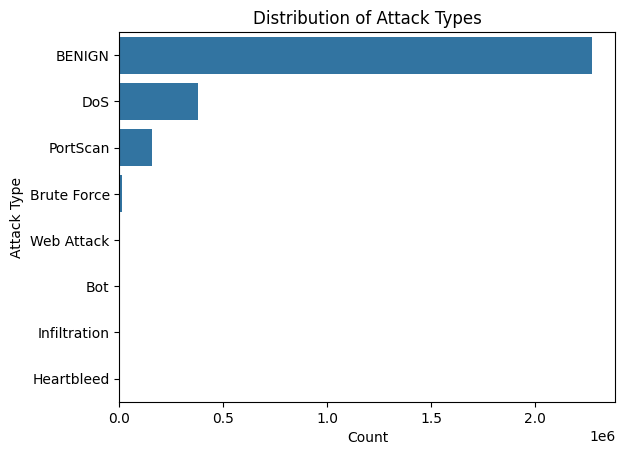

Label
BENIGN          2271320
DoS              379737
PortScan         158804
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


In [51]:
# Assuming 'df_data' is your DataFrame and it has a column 'Label' with all attack types
sns.countplot(y='Label', data=df_data, order=df_data['Label'].value_counts().index)
plt.title('Distribution of Attack Types')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()
print(df_data['Label'].value_counts())

### In our exploratory data analysis, we identified that our dataset is significantly imbalanced, with a larger number of 'Benign' instances compared to all other attacks. This imbalance can lead to biased predictive models that perform well on the majority class but poorly on the minority class.

### Correlation Matrix : Blue represents negative correlations, red represents positive correlations, and white or pale colors represent no correlation.

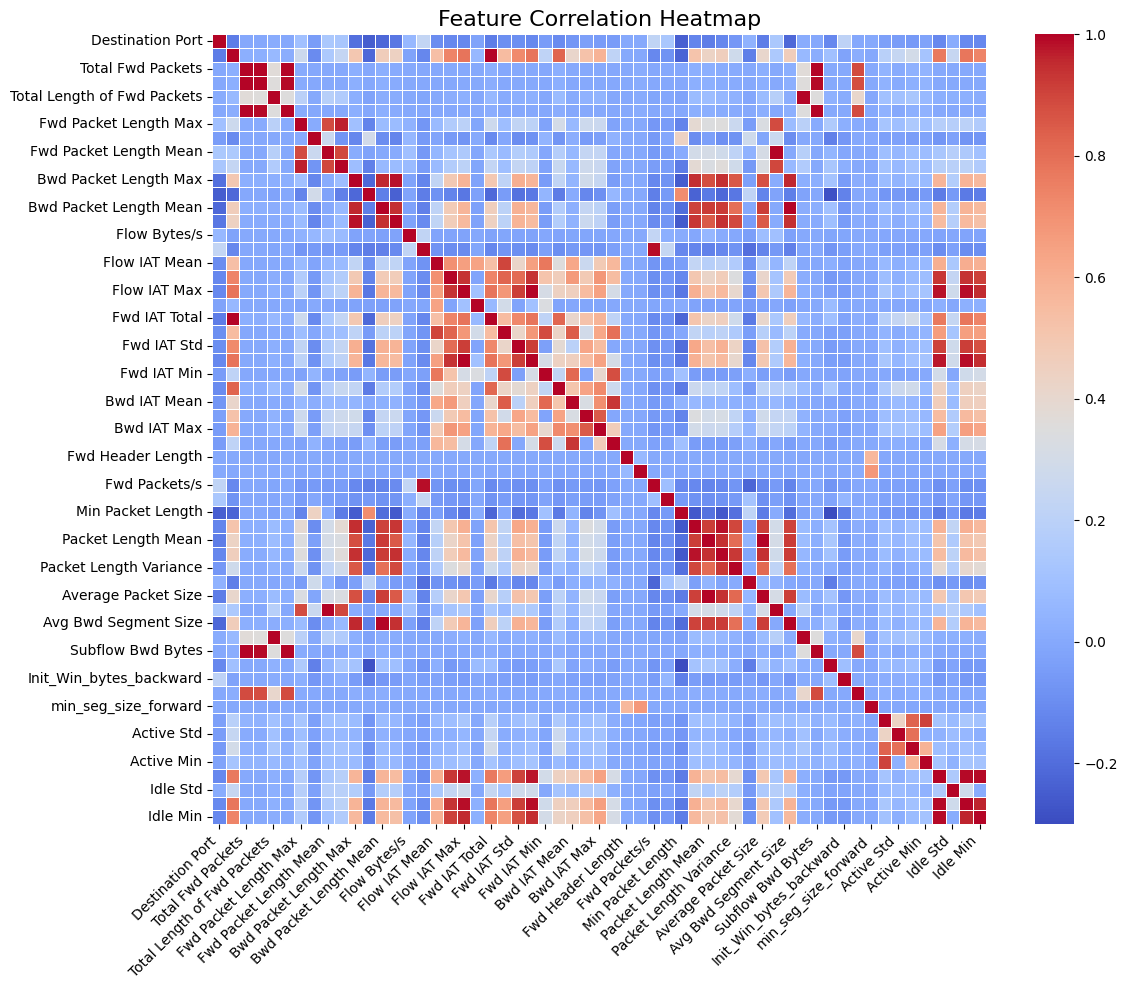

In [52]:
# Calculate the correlation matrix
corr_matrix = df_data[numerical_columns].corr()

# Plotting the heatmap with adjustments
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

### Since there are too many features, I focused on the most correlated features by selecting a subset

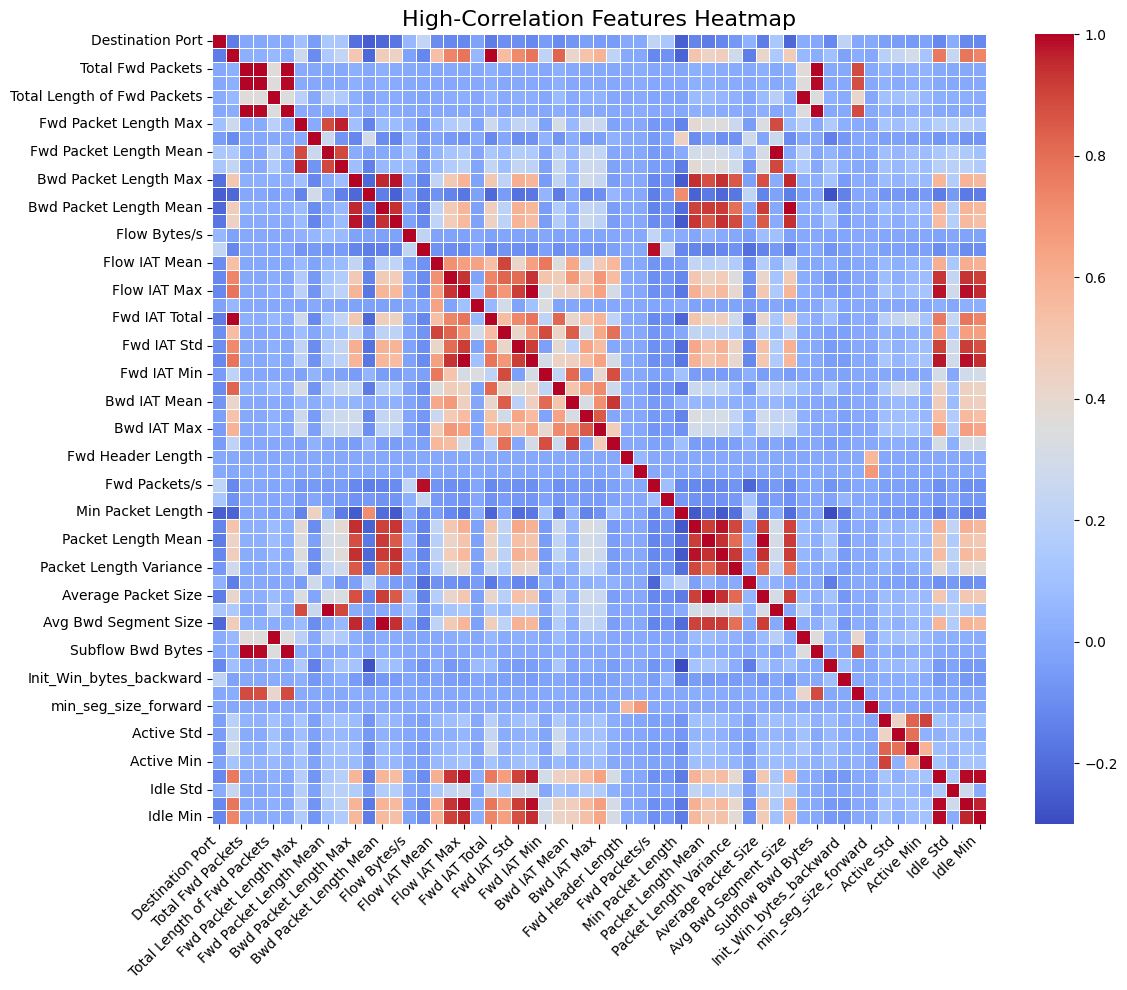

In [53]:
# Select top correlated features (optional)
corr_threshold = 0.5  # Example: Use a threshold to filter features
high_corr_features = corr_matrix.columns[(corr_matrix.abs() > corr_threshold).any()].tolist()

# Plot only the high-correlation features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[high_corr_features, high_corr_features], annot=False, cmap='coolwarm', linewidths=0.5)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title('High-Correlation Features Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

#### Since there are too many features, I focused on the most correlated features by selecting a subset and use a threshold to filter features. This particular heatmap visualizes the relationships among various network traffic features, which are crucial for identifying patterns that might suggest normal or malicious behaviors in network traffic data.

### Tabular summary of the most and least correlated features from a correlation matrix

In [54]:
def summarize_correlations(corr_matrix, n=5):
    # Create a DataFrame from the lower triangle of the correlation matrix, excluding the diagonal
    corr_df = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool))
    
    # Stack the DataFrame and reset the index to turn it into a long format
    long_corr = corr_df.stack().reset_index()
    long_corr.columns = ['Feature1', 'Feature2', 'Correlation']

    # Get the top n most correlated features
    top_correlations = long_corr.nlargest(n, 'Correlation')
    
    # Get the top n least correlated features
    least_correlations = long_corr.nsmallest(n, 'Correlation')

    return top_correlations, least_correlations

# Get the summaries
top_correlations, least_correlations = summarize_correlations(corr_matrix, n=5)

# Print or return these summaries as needed
print("Top Correlations:")
print(top_correlations)
print("\nLeast Correlations:")
print(least_correlations)

Top Correlations:
                   Feature1                     Feature2  Correlation
828    Avg Fwd Segment Size       Fwd Packet Length Mean     1.000000
873    Avg Bwd Segment Size       Bwd Packet Length Mean     1.000000
951       Subflow Bwd Bytes  Total Length of Bwd Packets     1.000000
907       Subflow Fwd Bytes  Total Length of Fwd Packets     0.999999
5    Total Backward Packets            Total Fwd Packets     0.999070

Least Correlations:
                    Feature1               Feature2  Correlation
1024  Init_Win_bytes_forward      Min Packet Length    -0.300436
1001  Init_Win_bytes_forward  Bwd Packet Length Min    -0.280821
629        Max Packet Length      Min Packet Length    -0.262888
700        Packet Length Std      Min Packet Length    -0.261159
574        Min Packet Length  Bwd Packet Length Std    -0.258712


### Box Plot to Check Outliers: Box plots help identify outliers within the dataset for each feature. Box plots for each numerical column


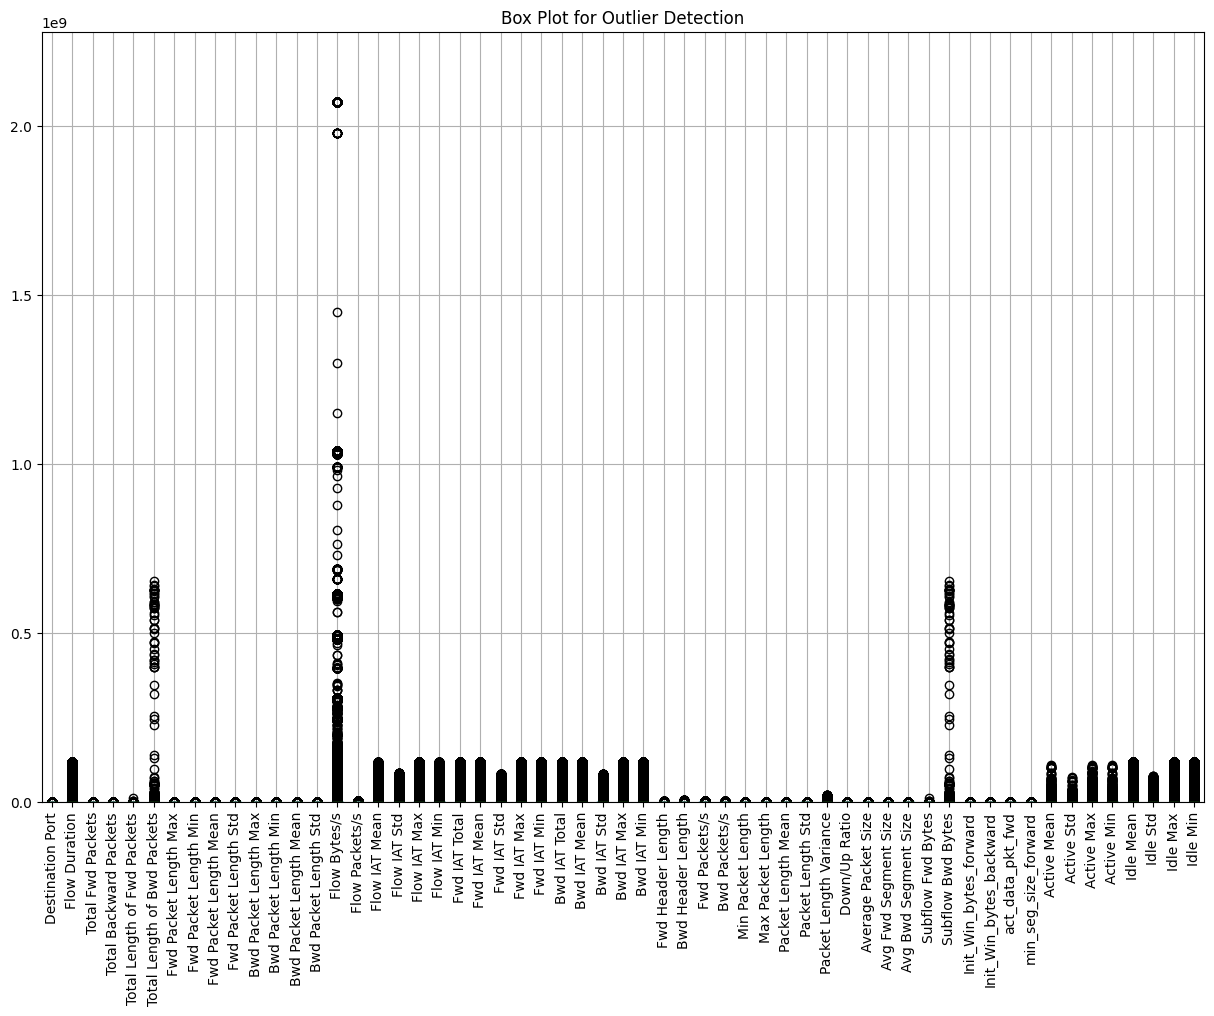

In [55]:
plt.figure(figsize=(15, 10))
df_data[numerical_columns].boxplot(rot=90)
plt.title("Box Plot for Outlier Detection")
plt.ylim(0, max(df_data[numerical_columns].max())*1.1)
plt.show()

### Focus on the "Flow Bytes/s" column only

In [56]:
df_data.shape

(2827876, 66)

(0.0, 2278100000.0)

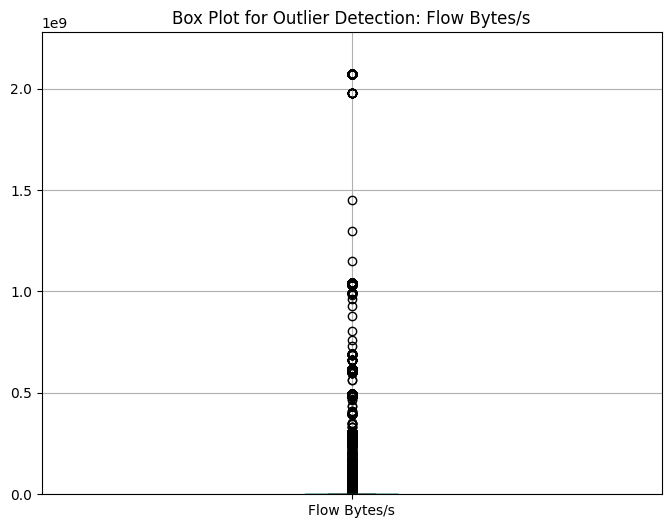

In [57]:
column_of_interest = 'Flow Bytes/s'
# Plot box plot for the selected column
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot for Outlier Detection: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1) 

### Handle Outliers : Capping the outliers instead of removing them ensures that extreme values are still present but limited to a reasonable range
* The first quartile Q1 is the 25th percentile
* The third quartile Q3 is the 75th percentile
* Any data point that’s 1.5 points below the lower bound quartile or above the upper bound quartile is an outlier. 
### The cap_outliers doesn't remove the outliers but caps them meaing outliers are adjusted or limited to fall within a certain range. 
### Any value that exceeds a predefined upper or lower bound is set to that boundary value. It modifies values that fall outside these bounds by capping them at the nearest bound.

In [58]:
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25) ##  The first quartile Q1 is the 25th percentile
    Q3 = df[col].quantile(0.75) ## The third quartile Q3 is the 75th percentile
    IQR = Q3 - Q1 ## The IQR is useful because it focuses on the middle 50% of the data and excludes the extreme values
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = df[col].clip(lower_bound, upper_bound)
    return df
df_data = cap_outliers(df_data, 'Flow Bytes/s')

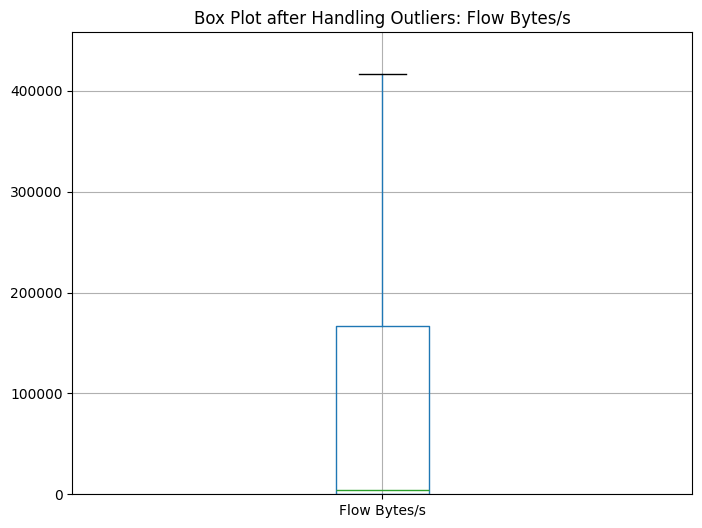

In [59]:
plt.figure(figsize=(8, 6))
df_data[[column_of_interest]].boxplot()
plt.title(f"Box Plot after Handling Outliers: {column_of_interest}")
plt.ylim(0, df_data[column_of_interest].max() * 1.1)
plt.show()

In [60]:
df_data['Label'].value_counts()

Label
BENIGN          2271320
DoS              379737
PortScan         158804
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

## Feature Engineering

### Label encoder

In [61]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder specifically to the 'Label' column
df_data['Label'] = le.fit_transform(df_data['Label'])

In [62]:
df_data['Label'].value_counts()

Label
0    2271320
3     379737
6     158804
2      13832
7       2180
1       1956
5         36
4         11
Name: count, dtype: int64

### To assign for each attack the specified number that were assign in the label encoder

In [63]:
le.classes_

array(['BENIGN', 'Bot', 'Brute Force', 'DoS', 'Heartbleed',
       'Infiltration', 'PortScan', 'Web Attack'], dtype=object)

### Data Splitting
#### Splitting of the data : HoldOut Validation Approach Train and test split.

#### Using stratify=y preserves the original class distribution in both training and testing sets, which is crucial for imbalanced datasets.

In [64]:
X = df_data.drop('Label',axis=1)
y = df_data['Label']
# Split the dataset into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

#### Verify the split

In [65]:
# Verify the split
print("\nTraining set class distribution:")
print(Counter(y_train))
print("\nTest set class distribution:")
print(Counter(y_test))


Training set class distribution:
Counter({0: 1589924, 3: 265816, 6: 111163, 2: 9682, 7: 1526, 1: 1369, 5: 25, 4: 8})

Test set class distribution:
Counter({0: 681396, 3: 113921, 6: 47641, 2: 4150, 7: 654, 1: 587, 5: 11, 4: 3})


* Perform undersampling on BENIGN and DoS using K-means clustering. cluster-based instance selection (CBIS). Removing samples from the majority class
dataset. 
* Perform oversampling on Infiltration and Heartbleed. SMOTE algorithm, which is a popular over-sampling technique
* the majority class are BENIGN and DoS and the minority class are DoS,PortScan,Brute Force,Web Attack,Bot,Infiltration,Heartbleed

In [66]:
# Check data type and missing values
print(f"Data type of y_train: {y_train.dtype}")
print(f"Missing values in y_train: {y_train.isnull().sum()}")

# Check the shape to ensure it's 1D
print(f"Shape of y_train: {y_train.shape}")

# Print class distribution
original_counts_train = Counter(y_train)
print("Original training class distribution:", original_counts_train)

Data type of y_train: int64
Missing values in y_train: 0
Shape of y_train: (1979513,)
Original training class distribution: Counter({0: 1589924, 3: 265816, 6: 111163, 2: 9682, 7: 1526, 1: 1369, 5: 25, 4: 8})


### Handling Class Imbalance:

#### ClusterCentroids with MiniBatchKMeans as the estimator

In [ ]:
# Step 1: Analyze original training class distribution
original_counts_train = Counter(y_train)
print("Original training class distribution:", original_counts_train)

# Step 2: Define sampling strategy
majority_classes = [0, 3, 6]
sampling_strategy = {}
for cls in majority_classes:
    if cls in original_counts_train:
        desired_count = max(1, int(0.1 * original_counts_train[cls]))
        sampling_strategy[cls] = desired_count
    else:
        print(f"Class {cls} not found in the training target vector.")

print("Sampling strategy:", sampling_strategy)

# Step 3: Initialize ClusterCentroids
cc = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=0),
    sampling_strategy=sampling_strategy,
    random_state=42
)

# Step 4: Apply undersampling to training data
X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

# Step 6: Verify resampled training class distribution
new_counts_train = Counter(y_train_resampled)
print("Resampled training class distribution:", new_counts_train)

# Step 7: Train the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Step 8: Evaluate the model on the untouched test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Original training class distribution: Counter({0: 1589924, 3: 265816, 6: 111163, 2: 9682, 7: 1526, 1: 1369, 5: 25, 4: 8})
Sampling strategy: {0: 158992, 3: 26581, 6: 11116}


#### Handle class imbalance : SMOTE (Synthetic Minority Over-sampling Technique)
#### SMOTE should be applied after splitting the data into training and testing sets. This is to ensure that the synthetic data points created do not leak from the test set into the training set, which could lead to overfitting:
##### How SMOTE works:

1. Identifying Neighbors: For a data point in the minority class, SMOTE finds its nearest neighbors in the feature space.
2. Synthesizing New Data: SMOTE selects one of these nearest neighbors and computes a line segment connecting the minority class data point and its selected neighbor. It then creates new, synthetic data points along this line.
3. Repeating: This process is repeated until the minority class is adequately represented and balances the dataset.


In [ ]:
# Define oversampling strategy for minority classes
oversampling_strategy = {5: 1000, 4: 1000}

# Initialize SMOTE
smote = SMOTE(sampling_strategy=oversampling_strategy, random_state=42)
X_train_resampled_over, y_train_resampled_over = smote.fit_resample(X_train_resampled, y_train_resampled)

print("\nAfter Oversampling, training class distribution:")
print(Counter(y_train_resampled_over))

#### After handling class imbalance

In [ ]:
# Function to plot class distribution with percentages
def plot_class_distribution(distribution, title):
    labels, values = zip(*distribution.items())
    total = sum(values)
    percentages = [(value / total) * 100 for value in values]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=percentages, y=labels, palette='Blues_d')

    # Loop through the bars and add the percentage labels to each bar
    for i, (percentage, label) in enumerate(zip(percentages, labels)):
        ax.text(percentage, i, f'{percentage:.5f}%', va='center')

    plt.xlabel('Percentage')
    plt.ylabel('Attack Type')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Original class distribution before handling imbalance
original_distribution = {
    'BENIGN': 2271320,
    'DoS': 379737,
    'PortScan': 158804,
    'Brute Force': 13832,
    'Web Attack': 2180,
    'Bot': 1956,
    'Infiltration': 36,
    'Heartbleed': 11
}

# Final class distribution after applying ClusterCentroids and SMOTE
final_distribution = {
    'BENIGN': 158992,
    'DoS': 1369,
    'PortScan': 9682,
    'Brute Force': 26581,
    'Web Attack': 1000,
    'Bot': 1526,
    'Infiltration': 11116,
    'Heartbleed': 1000
}

# Plot the class distribution before handling imbalance
plot_class_distribution(original_distribution, 'Class Distribution Before Handling Imbalance')

# Plot the class distribution after handling imbalance
plot_class_distribution(final_distribution, 'Class Distribution After Handling Imbalance')

### Feature Selection:

#### Feature Importance Analysis

In [ ]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Train the RandomForestClassifier
#rf.fit(X_train_downsampling, y_train)

rf.fit(X_train_resampled_over, y_train_resampled_over)

# Calculate feature importances
feature_importances = rf.feature_importances_

# Convert to a pandas DataFrame for easier visualization
importance_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance
importance_series = importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
importance_series.plot(kind='bar', color='skyblue')
plt.title('Feature Importance Using RandomForest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#### Mutual Information

##### Calculate the importance for every feature

In [ ]:
# Calculate mutual information between numerical features and the target
importances = mutual_info_classif(X_train_resampled_over, y_train_resampled_over)

# Convert to a pandas DataFrame for easier visualization
mi_series = pd.Series(importances, index=X.columns)

# Sort the features by importance
mi_series = mi_series.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='skyblue')
plt.title('Mutual Information Between Features and Label')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

##### Calculate the sum of importance scores

In [ ]:
# Sort the feature importances along with the feature names
f_list = sorted(zip(map(lambda x: round(x, 4), importances), X_train.columns), reverse=True) ## 

# Initialize variables
Sum = 0
fs = []

# Calculate the sum of feature importances and store features
for i in range(len(f_list)):
    Sum += f_list[i][0]  # Summing up the importance scores
    fs.append(f_list[i][1])  # Append the feature name to the list

# Optional: Print or return the feature importances and the sum
print("Sum of feature importances:", Sum)

##### We select the important feature until the accumulated importance reaches 90%

In [67]:
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), X_train.columns), reverse=True)
Sum2 = 0
fs = []

for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    
    if Sum2 >= 0.9:
        break

In [68]:
# print(len(fs))
# print(fs)
feature_selected = ['Packet Length Variance', 'Packet Length Std', 'Packet Length Mean', 'Average Packet Size', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Bwd Packet Length Mean', 'Avg Bwd Segment Size', 'Init_Win_bytes_backward', 'Destination Port', 'Max Packet Length', 'Bwd Packet Length Max', 'Fwd Packet Length Max', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Std', 'Flow IAT Max', 'Init_Win_bytes_forward', 'Fwd IAT Max', 'Bwd Packets/s', 'Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Flow Bytes/s', 'Fwd Packet Length Std', 'Fwd Header Length', 'Flow Packets/s', 'Flow IAT Mean', 'Flow Duration', 'Bwd Header Length', 'Fwd Packets/s', 'Fwd IAT Mean', 'Flow IAT Std', 'Fwd IAT Total', 'Fwd IAT Std', 'Bwd IAT Max', 'Total Backward Packets', 'Bwd IAT Total', 'Bwd IAT Mean', 'Total Fwd Packets', 'Bwd IAT Std', 'Active Min', 'Active Mean', 'Idle Max', 'Active Max', 'Bwd IAT Min']

### Standardization

#### Apply Z-Score Normalization : In our preprocessing steps, we applied Z-score normalization to our numerical features using StandardScaler. This method standardizes the features so that each has a mean of zero and a standard deviation of one, aligning with the Z-score formula.

In [69]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler only on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train_resampled_over[numerical_columns])

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test[numerical_columns])

#### This code handles the integration of scaled numerical data with unscaled categorical data

In [ ]:
# Convert the scaled data back into DataFrames for ease of use
# columns=numerical_columns: This specifies the column names for the new DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_columns)

# axis=1 means along "columns". It's a column-wise operation.
X_train_final = pd.concat([X_train_scaled_df, X_train_resampled_over[categorical_columns].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test[categorical_columns].reset_index(drop=True)], axis=1)

# Print the shape of the final datasets to verify the concatenation
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

### This cell represent how data are represented before being scaled

In [ ]:
X_train_final.head(5)

### This cell represent how data are represented after being scaled

In [ ]:
X_test_final.head(5)

## Machine Learning Models

### Training Models on all the features
#### We perform k-fold cross validation on the entire dataset

In [73]:
score = []  # For normal training results
score_hyper = []  # For hyperparameter tuning results

In [74]:
def save_best_params_to_json(model_name, best_params):
    filename= "best_params_multiclass_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [75]:
def save_best_fs_params_to_json(model_name, best_params):
    filename= "best_params_fs_multiclass_multiple_models.json"
    # Check if the file already exists
    if os.path.exists(filename):
        # Load existing data
        with open(filename, 'r') as file:
            data = json.load(file)
    else:
        # Create a new dictionary if the file does not exist
        data = {}

    # Update the dictionary with the new model's best parameters
    data[model_name] = best_params

    # Write updated dictionary back to the JSON file
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)

In [76]:
mlflow.set_tracking_uri("http://localhost:5001")

## 1. Random Forest Classifier

### Training 

In [ ]:
rfc = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass")
mlflow.start_run(run_name="rfc_multi_model",nested=True)
mlflow.log_params(rfc.get_params())
rfc.fit(X_train_final, y_train_resampled_over)

### K-Fold  Cross Validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
rf_cross = RandomForestClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
rf_cross_scores = cross_validate(rf_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", rf_cross_scores['test_score'].mean())
print(rf_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = rfc.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred) # function calculates MCC by comparing the true labels (y_test) with the predicted labels (y_pred).

score.append(['Random Forest', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_rfc = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rfc, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning:
* GridSearchCV exhaustively searches through all possible combinations of the provided hyperparameters.

In [ ]:
# Define parameter grid
param_grid = { 
    'n_estimators': [25, 50, 100, 200, 300], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9, 12, 15], 
    'max_leaf_nodes': [3, 6, 9, 12, 15], 
} 

# Initialize RandomizedSearchCV with a specified number of iterations (e.g., n_iter=10)
random_search = RandomizedSearchCV(
    RandomForestClassifier(), 
    param_distributions=param_grid, 
    n_iter=10,  # Number of parameter settings that are sampled
    random_state=42, 
    cv=5, 
    verbose=1,
    n_jobs=-1
)

mlflow.set_experiment("hyperparameter_tuning_all_features_multiclass")
mlflow.end_run()

# automatically starts and ends an MLflow run
mlflow.start_run(run_name="random_forest_tuned_multiclass")
# Fit the RandomForest model on the training data
random_search.fit(X_train_final, y_train_resampled_over)

# Save the best parameters
model_name = "Random Forest"
best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_model_mlflow")
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Random Forest (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_rf.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_tuned = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_tuned, tpr_tuned, color='blue', label=f'ROC Curve (Class 1) (AUC = {auc_tuned:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned RandomForest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_tuned)

In [ ]:
cm_rfc_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rfc_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 2. XGB

### Training

In [ ]:
# Initialize the XGBoost model
xgb = XGBClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass")
mlflow.start_run(run_name="xgb_multi_model",nested=True)
mlflow.log_params(xgb.get_params())
# Fit the RandomForest model on the training data
xgb.fit(X_train_final, y_train_resampled_over)

### K-fold Cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
xgb_cross = XGBClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
xgb_cross_scores = cross_validate(xgb_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", xgb_cross_scores['test_score'].mean())
print(xgb_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = xgb.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['XGB', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter tuning

In [ ]:
# Set the MLflow tracking URI and experiment
mlflow.set_experiment("hyperparameter_tuning_all_features_multiclass")

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400],          # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 5, 7, 9],                     # Maximum depth of a tree
    'subsample': [0.6, 0.7, 0.8, 1.0]              # Subsample ratio of the training instances
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_grid_xgb,
    scoring='f1_weighted',
    n_iter=10,  # Number of parameter settings sampled
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="xgb_tuned_multiclass")
# Fit random search to the data
random_search_xgb.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = random_search_xgb.best_params_
print("Best Hyperparameters for XGBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_xgb.best_estimator_, "xgb_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "XGB"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best XGBoost model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['XGB (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_xgb.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_xgb, tpr_xgb, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_xgb = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'ROC Curve XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_tuned)

In [ ]:
cm_xgb_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 3. Decision Tree

### Training

In [ ]:
# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass")
mlflow.start_run(run_name="decision_tree",nested=True)
mlflow.log_params(dt.get_params())
# Fit the RandomForest model on the training data
dt.fit(X_train_final, y_train_resampled_over)

### k- fold cross

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
DT_cross = DecisionTreeClassifier(random_state=42)

# Perform k-fold cross-validation with multiple scoring metrics
DT_cross_scores = cross_validate(DT_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", DT_cross_scores['test_score'].mean())
print(DT_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred_dt = dt.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Decision Tree ', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion Matrix

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
param_grid_dt = {
    'max_depth': [10, 20, 30, 40, 50],             # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],           # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4, 6],              # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None]         # Number of features to consider at each split
}

# Initialize RandomizedSearchCV for DecisionTreeClassifier
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid_dt,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

mlflow.set_experiment("hyperparameter_tuning_all_features_multiclass")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="decision_tree_tuned_multiclass")
# Fit random search to the data
random_search_dt.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = random_search_dt.best_params_
print("Best Hyperparameters for Decision Tree:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_dt.best_estimator_, "Decision_Tree_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "Decision Tree"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper.append(['Decision Tree (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_dt.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_dt, tpr_dt, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_dt = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'ROC Curve Decision Tree (AUC = {auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_tuned)

In [ ]:
# Compute the confusion matrix
cm_dt_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 4. Logistic Regression

### Training

In [ ]:
# Initialize the Logistic Regression model
lr = LogisticRegression(random_state=42)
mlflow.set_experiment("training_all_features_multiclass")
mlflow.start_run(run_name="logistic_regression",nested=True)
mlflow.log_params(lr.get_params())
lr.fit(X_train_final, y_train_resampled_over)

### k-fold cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
lr_cross = LogisticRegression(random_state=42, solver='saga', max_iter=1000)

# Perform k-fold cross-validation with multiple scoring metrics
lr_cross_scores = cross_validate(lr_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", lr_cross_scores['test_score'].mean())
print(lr_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['Logistic Regression', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],
    'C': [0.01, 0.1, 1, 10, 100],  # More values to explore with RandomizedSearch
    'max_iter': [500, 1000, 2000, 3000]
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize RandomizedSearchCV
clf = RandomizedSearchCV(
    estimator=log_model,
    param_distributions=param_grid,  # Use param_distributions for RandomizedSearchCV
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,
    verbose=True,
    n_jobs=-1,
    scoring='f1_weighted',
    random_state=42  # Ensure reproducibility
)

mlflow.set_experiment("hyperparameter_tuning_all_features_multiclass")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run
mlflow.start_run(run_name="logistic_regression_tuned_multiclass")
clf.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = clf.best_params_
print("Best parameters found: ", best_params)
print("Best cross-validated score: ", clf.best_score_)

# Log the best parameters
mlflow.log_params(best_params)

# Log the best estimator as a model artifact
mlflow.sklearn.log_model(clf.best_estimator_, "logistic_regression_model_mlflow")

# Save the best parameters to a JSON file (assuming save_best_params_to_json is defined)
model_name = "Logistic Regression"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Get the best model from GridSearchCV
best_lr = clf.best_estimator_

# Validating the model with training data (optional)
train_score = best_lr.score(X_train_final, y_train_resampled_over)
print(f'Accuracy on training set: {train_score:.3f}')

# Testing the best logistic regression model (after hyperparameter tuning)
y_pred = best_lr.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper.append(['Logistic Regression (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_lr.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_lr, tpr_lr, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_lr = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'ROC Curve Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_tuned)

In [ ]:
cm_lr_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 5. CatBoost Model:
* CatBoost is preferred when dealing with datasets containing categorical features, as it automatically handles them without preprocessing. 
* It also offers built-in methods for handling missing values and is robust to overfitting. 
### Training

In [ ]:
catboost = CatBoostClassifier(verbose=0, random_state=42)
mlflow.set_experiment("training_all_features_multiclass")
mlflow.start_run(run_name="catboost_default", nested=True)
mlflow.log_params(catboost.get_params())
catboost.fit(X_train_final, y_train_resampled_over)

### k-fold cross validation

In [ ]:
# Define K-Fold cross-validator
kfold_validation = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the classifier
catBoost_cross = CatBoostClassifier()

# Perform k-fold cross-validation with multiple scoring metrics
catBoost_cross_scores = cross_validate(catBoost_cross, X, y, cv=kfold_validation, scoring='accuracy', return_train_score=True)

# Print the scores for each fold and metric
print("Average Accuracy Score:", catBoost_cross_scores['test_score'].mean())
print(catBoost_cross_scores)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = catboost.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score.append(['CatBoost', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion Matrix

In [ ]:
cm_catboost = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_catboost, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid_catboost = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [500, 1000, 1500],
    'l2_leaf_reg': [1, 3, 5]
}

grid_search_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_distributions=param_grid_catboost,
    n_iter=10,  # Number of parameter settings to sample (adjustable)
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_all_features_multiclass")
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="CatBoost_tuned")
# Fit RandomizedSearchCV to the data
grid_search_catboost.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = grid_search_catboost.best_params_
print("Best Hyperparameters for CatBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(grid_search_catboost.best_estimator_, "CatBoost_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "CatBoost"
save_best_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Get the best model from GridSearchCV
best_catboost = grid_search_catboost.best_estimator_


# Testing the best logistic regression model (after hyperparameter tuning)
y_pred = best_catboost.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper.append(['CatBoost (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"MCC: {mcc :.2f}%")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_catboost.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_catboost, tpr_catboost, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_catboost = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost, tpr_catboost, color='blue', label=f'ROC Curve Cat Boost (AUC = {auc_catboost:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned CatBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score CatBoost:", auc_catboost)

In [ ]:
cm_catboost_tunned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_catboost_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## DataFrames for Model Metrics:

### After collecting the results in score and score_hyper , I have created a new DataFrames to display the results (accuracy, recall, etc.), as shown below

In [117]:
# Define the columns for the tables
columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'MCC']

# Create a DataFrame for the normal training results
df_normal = pd.DataFrame(score, columns=columns)

# Create a DataFrame for the hyperparameter tuning results
df_hyper = pd.DataFrame(score_hyper, columns=columns)

In [ ]:
print("Normal Training Results:")
df_normal

In [ ]:
print("\nHyperparameter Tuning Results:")
df_hyper

### Save df_normal as a PNG

In [172]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_normal, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table

plt.savefig('df_normal_table.png')  # Save the figure as a PNG file
plt.close()

### Save df_hyper as a PNG

In [170]:
from pandas.plotting import table


In [171]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_hyper, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table

plt.savefig('df_hyper_table.png')  # Save the figure as a PNG file
plt.close()

## Plot and Save Multiple Confusion Matrices

In [ ]:
# Define the labels from your dataset
labels = le.classes_

confusion_matrices = [
    (cm_rfc_tuned, "Random Forest"),
    (cm_xgb_tuned, "XGBoost"),
    (cm_lr_tuned, "Logistic Regression"),
    (cm_dt_tuned, "Decision Tree"),
    (cm_catboost_tunned, "CatBoost")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices_multiclass.png')
plt.show()

## K-fold cross-validation

In [ ]:
# Assuming the cross-validation score data is correct as provided
models = ['CatBoost', 'Logistic Regression', 'Decision Tree', 'XGBoost', 'Random Forest']
results = {
    'Model': models,
    'Fold-1': [scores['test_score'][0] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-2': [scores['test_score'][1] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-3': [scores['test_score'][2] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-4': [scores['test_score'][3] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]],
    'Fold-5': [scores['test_score'][4] for scores in [catBoost_cross_scores, lr_cross_scores, DT_cross_scores, xgb_cross_scores, rf_cross_scores]]
}

df_results = pd.DataFrame(results)

# Avoid converting to strings, calculate mean and standard deviation directly
df_results['Mean Accuracy'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].mean(axis=1)
df_results['Standard Deviation'] = df_results[['Fold-1', 'Fold-2', 'Fold-3', 'Fold-4', 'Fold-5']].std(axis=1)

# Formatting the output for display (not altering the actual DataFrame)
formatted_df = df_results.copy()
formatted_df.iloc[:, 1:] = formatted_df.iloc[:, 1:].map(lambda x: f"{x:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Creating the table
table = ax.table(cellText=formatted_df.values, colLabels=formatted_df.columns, cellLoc='center', loc='center', colWidths=[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.13])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Add a title
plt.title('Cross-Validation Results for Various Models')

# Save the figure
plt.savefig('Cross Validation for Multiclass.png')

# Display the plot
plt.show()

## Save All ROC curve

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(fpr_tuned, tpr_tuned, color='blue', label='Random Forest (AUC = {:.2f})'.format(auc_tuned))
plt.plot(fpr_xgb, tpr_xgb, color='green', label='XGBoost (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_dt, tpr_dt, color='purple', label='Decision Tree (AUC = {:.2f})'.format(auc_dt))
plt.plot(fpr_lr, tpr_lr, color='orange', label='Logistic Regression (AUC = {:.2f})'.format(auc_lr))
plt.plot(fpr_catboost, tpr_catboost, color='cyan', label='CatBoost Bayes (AUC = {:.2f})'.format(auc_catboost))

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for All Tuned Models')
plt.legend(loc='lower right')
plt.grid(True)

# Save the combined plot
plt.savefig('all_roc_curves.png')
plt.show()

# ---------------------------Feature Selected-------------------------

# Training models with features selected

In [125]:
X_train_fs = X_train_final[feature_selected]
X_test_fs = X_test_final[feature_selected]

In [126]:
score_fs = []  # For normal training results
score_hyper_fs = []  # For hyperparameter tuning results

In [127]:
mlflow.set_tracking_uri("http://localhost:5001")

## 1. Random Forest Classifier

### Training 

In [ ]:
rfc_fs = RandomForestClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass_fs")
mlflow.start_run(run_name="rfc_fs_model",nested=True)
mlflow.log_params(rfc_fs.get_params())
rfc_fs.fit(X_train_fs, y_train_resampled_over)

### Testing

In [ ]:
y_pred = rfc_fs.predict(X_test_fs)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Random Forest', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()


print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_rf= confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_multiclass")
mlflow.end_run()

mlflow.start_run(run_name="random_forest_fs_tuned",nested=True)
# Fit random search to the data
random_search.fit(X_train_fs, y_train_resampled_over)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

# Save the best parameters
model_name = "Random Forest fs"
best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "random_forest_fs_model_mlflow")

save_best_fs_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Random Forest (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
cm_rfc_fs_tunned= confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rfc_fs_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
# Assuming `best_xgb` is the trained model that should be used here
y_pred_prob_tuned = best_rf.predict_proba(X_test_fs)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_rf_fs, tpr_rf_fs, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_rf_fs = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_fs, tpr_rf_fs, color='blue', label=f'ROC Curve Random Forest (AUC = {auc_rf_fs:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("AUC Score:", auc_rf_fs)

## 2. XGB

### Training

In [ ]:
# Initialize the XGBoost model
xgb_fs = XGBClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass_fs")
mlflow.start_run(run_name="xgb_fs_model",nested=True)
mlflow.log_params(xgb_fs.get_params())
xgb_fs.fit(X_train_fs, y_train_resampled_over)

In [ ]:
# Make predictions on the test data
y_pred = xgb_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['XGB Model', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

In [ ]:
# Assume y_test and y_pred are defined elsewhere in your code
# Compute the confusion matrix
cm_xgb= confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100],  # Reduced to 2 values
    'learning_rate': [0.05, 0.1],  # Reduced to 2 values
    'max_depth': [3, 5],  # Reduced to 2 values
    'subsample': [0.8, 1.0],  # Reduced to 2 values
    'colsample_bytree': [0.8, 1.0],  # Reduced to 2 values
    'gamma': [0, 0.1]  # Reduced to 2 values
}

# Initialize RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_dist_xgb,
    n_iter=50,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
mlflow.set_experiment("hyperparameter_tuning_fs_multiclass")
mlflow.end_run()
mlflow.start_run(run_name="xgb_fs_tuned",nested=True)

# Fit random search to the data
random_search_xgb.fit(X_train_fs, y_train_resampled_over)


# Save the best parameters
model_name = "XGB fs"

best_params = random_search.best_params_
mlflow.log_params(best_params)

# Optionally log the model as well
mlflow.sklearn.log_model(random_search.best_estimator_, "xgb_model_fs_mlflow")


save_best_fs_params_to_json(model_name, best_params)

# Print best parameters for XGBoost
print("Best Hyperparameters for XGBoost:", random_search_xgb.best_params_)

### Evaluation Steps

In [ ]:
# Evaluate the best model on the test set
best_xgb = random_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test_fs)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['XGB(Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### ROC curve for Random Forest

In [ ]:
# Get the feature names from the trained model
trained_feature_names = best_xgb.get_booster().feature_names

# Reorder X_test_final to match the feature names used during training
X_test_final_aligned = X_test_final[trained_feature_names]

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_xgb.predict_proba(X_test_final_aligned)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_xgb_fs, tpr_xgb_fs, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_xgb_fs = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_fs, tpr_xgb_fs, color='blue', label=f'ROC Curve XGBoost (AUC = {auc_xgb_fs:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned XGBoost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("AUC Score:", auc_xgb_fs)


In [ ]:
cm_xgb_fs_tunned= confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_xgb_fs_tunned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 3. Decision Tree

### Training

In [ ]:
# Initialize the Decision Tree model
dt_fs = DecisionTreeClassifier(random_state=42)
mlflow.set_experiment("training_all_features_multiclass_fs")
mlflow.start_run(run_name="decision_tree",nested=True)
mlflow.log_params(dt_fs.get_params())
dt_fs.fit(X_train_fs, y_train_resampled_over)

### Testing

In [ ]:
# Make predictions on the test data
y_pred_dt = dt_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Decision Tree ', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion Matrix

In [ ]:
cm_dt_fs = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt_fs, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define parameter grid for Decision Tree
param_dist_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random']
}

# Initialize RandomizedSearchCV for Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # Adjusted number of iterations
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

mlflow.set_experiment("hyperparameter_tuning_fs_multiclass")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="decision_tree_tuned_multiclass_fs")
# Fit random search to the data
random_search_dt.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = random_search_dt.best_params_
print("Best Hyperparameters for Decision Tree:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(random_search_dt.best_estimator_, "Decision_Tree_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "Decision Tree fs"
save_best_fs_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
best_dt = random_search_dt.best_estimator_
y_pred = best_dt.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Decision Tree (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_dt.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_dt_fs, tpr_dt_fs, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_dt_fs = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt_fs, tpr_dt_fs, color='blue', label=f'ROC Curve Decision Tree (AUC = {auc_dt_fs:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_dt_fs)

### Compute the confusion matrix

In [ ]:
cm_dt_fs_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_dt_fs_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 4. Logistic Regression
### Training


In [ ]:
# Initialize the Logistic Regression model
lr_fs = LogisticRegression(random_state=42)
mlflow.set_experiment("training_all_features_multiclass_fs")

mlflow.start_run(run_name="logistic_regression",nested=True)
mlflow.log_params(lr_fs.get_params())
lr_fs.fit(X_train_fs, y_train_resampled_over)

### Testing

In [ ]:
# Make predictions on the test data
y_pred = lr_fs.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['Logistic Regression', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### Confusion matrix

In [ ]:
cm_lr_fs = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr_fs, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],           # Simplified to only 'l2' for now to reduce complexity
    'C': [0.1, 1.0],             # Reduced range for C
    'solver': ['liblinear'],     # Using 'liblinear' as it's often faster for smaller datasets
    'max_iter': [1000],          # Standard max_iter to see if it converges
    'tol': [1e-4]                # Standard tolerance
}

# Initialize the Logistic Regression model
log_model = LogisticRegression(random_state=42)

# Initialize GridSearchCV
clf = GridSearchCV(log_model, param_grid=param_grid, cv=3, verbose=True, n_jobs=-1, scoring='f1_weighted')

mlflow.set_experiment("hyperparameter_tuning_fs_multiclass")

# Ensure any existing runs are closed
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="logistic_regression_tuned_multiclass_fs")
# Fit GridSearchCV to the data
clf.fit(X_train_final, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = clf.best_params_
print("Best parameters found: ", best_params)
print("Best cross-validated score: ", clf.best_score_)

# Log the best parameters
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(clf.best_estimator_, "logistic_regression_model_mlflow")

# Save the best parameters to a JSON file
model_name = "Logistic Regression fs"
save_best_fs_params_to_json(model_name, best_params)

### Evaluation Steps

In [ ]:
best_lr = clf.best_estimator_
y_pred = best_lr.predict(X_test_final)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_hyper_fs.append(['Logistic Regression (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc}
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"F1 Score: {f1 * 100:.4f}")
print(f"MCC: {mcc:.4f}")

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
# Assuming class 1 is the class of interest
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = best_lr.predict_proba(X_test_final)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_lr_fs, tpr_lr_fs, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_lr_fs = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_fs, tpr_lr_fs, color='blue', label=f'ROC Curve Logistic Regression (AUC = {auc_lr_fs:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_lr_fs)

### Compute the confusion matrix

In [ ]:
cm_lr_fs_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr_fs_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 5. CatBoost Model
### Training

In [ ]:
catboost_fs = CatBoostClassifier(verbose=0, random_state=42)

# Set MLflow experiment
mlflow.set_experiment("training_all_features_multiclass_fs")

# Start MLflow run
mlflow.start_run(run_name="catboost_default", nested=True)
mlflow.log_params(catboost_fs.get_params())
catboost_fs.fit(X_train_fs, y_train_resampled_over)

In [ ]:
# Make predictions on the test data
y_pred = catboost_fs.predict(X_test_final)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

score_fs.append(['CatBoost', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])

metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc, }
mlflow.log_metrics(metrics)
mlflow.end_run()
# Print the results
print("Accuracy:", accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('MCC:', mcc)

In [ ]:
cm_catboost_fs = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_catboost_fs, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning with GridSearchCV
param_grid_catboost = {
    'depth': [6, 10],  # reduced from [6, 8, 10]
    'learning_rate': [0.01, 0.1],  # reduced from [0.01, 0.05, 0.1]
    'iterations': [1000],  # fixed at the higher value
    'l2_leaf_reg': [1, 5],  # reduced from [1, 3, 5, 7]
    'border_count': [32, 128]  # reduced from [32, 64, 128]
}


grid_search_catboost = GridSearchCV(
    estimator=CatBoostClassifier(verbose=0, random_state=42),
    param_grid=param_grid_catboost,
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    n_jobs=-1
)

mlflow.set_experiment("hyperparameter_tuning_fs_multiclass")
mlflow.end_run()

# Start a new MLflow run within a context manager
mlflow.start_run(run_name="CatBoost_tuned")
# Fit RandomizedSearchCV to the data
grid_search_catboost.fit(X_train_fs, y_train_resampled_over)

# Retrieve and log the best parameters
best_params = grid_search_catboost.best_params_
print("Best Hyperparameters for CatBoost:", best_params)
mlflow.log_params(best_params)

# Optionally log the model
mlflow.sklearn.log_model(grid_search_catboost.best_estimator_, "CatBoost_model_mlflow")

# Save the best parameters to a JSON file (optional, not recommended within the context block)
model_name = "CatBoost"
save_best_fs_params_to_json(model_name, best_params)

### Evaluation

In [ ]:
best_catboost = grid_search_catboost.best_estimator_

# Validating the model with training data (optional)
train_score = best_catboost.score(X_train_fs, y_train_resampled_over)
print(f'Accuracy on training set: {train_score:.3f}')

# Testing the best logistic regression model (after hyperparameter tuning)
y_pred = best_catboost.predict(X_test_fs)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

# Append the results to the hyperparameter-tuned score list
score_hyper_fs.append(['CatBoost (Tuned)', f'{accuracy:.4f}', 
    f'{recall:.4f}', 
    f'{precision:.4f}', 
    f'{f1:.4f}', 
    f'{mcc:.4f}'])
metrics = {"accuracy" : accuracy , "recall" :recall, "precision":precision,"f1":f1,"mcc":mcc }
mlflow.log_metrics(metrics)
# End the MLflow run
mlflow.end_run()
# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"MCC: {mcc:.2f}%")

In [ ]:
cm_catboost_fs_tuned = confusion_matrix(y_test, y_pred)

# Define the labels from your dataset (adjust labels as per your actual data)
labels = le.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_catboost_fs_tuned, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### The Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) :
* are important tools for evaluating the performance of a binary classifier. The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings, providing insight into the trade-off between sensitivity (true positive rate) and specificity (false positive rate). The AUC provides a single scalar value which measures the overall ability of the model to discriminate between the positive and negative classes across all possible thresholds. Essentially, a higher AUC value indicates better model performance.

In [ ]:
y_test_binary = (y_test == 1).astype(int)

# Calculate predicted probabilities for the class of interest
y_pred_prob_tuned = grid_search_catboost.predict_proba(X_test_fs)[:, 1]  # Index for class 1

# Compute ROC curve and AUC score for the binary case
fpr_catboost_fs, fpr_catboost_fs, thresholds_tuned = roc_curve(y_test_binary, y_pred_prob_tuned)
auc_catboost_fs = roc_auc_score(y_test_binary, y_pred_prob_tuned)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_catboost_fs, fpr_catboost_fs, color='blue', label=f'ROC Curve Catboost (AUC = {auc_catboost_fs:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Tuned Catboost')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("AUC Score:", auc_catboost_fs)

## Save confusion matrix fs

In [ ]:
# Define the labels from your dataset
labels = le.classes_

confusion_matrices = [
    (cm_rfc_fs_tunned, "Random Forest"),
    (cm_xgb_fs_tunned, "XGBoost"),
    (cm_lr_fs_tuned, "Logistic Regression"),
    (cm_dt_fs_tuned, "Decision Tree"),
    (cm_catboost_fs_tuned, "CatBoost")
]

# Setup the matplotlib figure and axes
num_matrices = len(confusion_matrices)
fig, axes = plt.subplots(nrows=1, ncols=num_matrices, figsize=(5 * num_matrices, 5))  # Adjust size as needed

# Check if only one row of subplots, make axes iterable
if num_matrices == 1:
    axes = [axes]

# Loop through the confusion matrices and corresponding axes
for ax, (cm, title) in zip(axes, confusion_matrices):
    # Plotting the confusion matrix using seaborn's heatmap function
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(title)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

# Tight layout to ensure subplots do not overlap
plt.tight_layout()

# Save the figure
plt.savefig('all_confusion_matrices_multiclass_fs.png')
plt.show()

## Save All ROC curve

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the ROC curves for each model
plt.plot(fpr_rf_fs, tpr_rf_fs, color='blue', label='Random Forest FS (AUC = {:.2f})'.format(auc_rf_fs))
plt.plot(fpr_xgb_fs, tpr_xgb_fs, color='green', label='XGBoost FS (AUC = {:.2f})'.format(auc_xgb_fs))
plt.plot(fpr_dt_fs, tpr_dt_fs, color='purple', label='Decision Tree FS (AUC = {:.2f})'.format(auc_dt_fs))
plt.plot(fpr_lr_fs, tpr_lr_fs, color='orange', label='Logistic Regression FS (AUC = {:.2f})'.format(auc_lr_fs))
plt.plot(fpr_catboost_fs, fpr_catboost_fs, color='cyan', label='CatBoost FS (AUC = {:.2f})'.format(auc_catboost_fs))

# Plot random chance line (the diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves for All Tuned Models with Feature Selected')

# Add legend
plt.legend(loc='lower right')

# Add grid
plt.grid(True)

# Save the combined plot
plt.savefig('all_roc_curves_fs.png')

# Display the plot
plt.show()

## DataFrames for Model Metrics:

### After collecting the results in score_fs and score_hyper_fs , I have created a new DataFrames to display the results (accuracy, recall, etc.), as shown below

In [165]:
# Define the columns for the tables
columns = ['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'MCC']

# Create a DataFrame for the normal training results
df_normal_fs = pd.DataFrame(score_fs, columns=columns)

# Create a DataFrame for the hyperparameter tuning results
df_hyper_fs = pd.DataFrame(score_hyper_fs, columns=columns)

In [ ]:
print("Normal Training Results:")
df_normal_fs

In [ ]:
print("\nHyperparameter Tuning Results:")
df_hyper_fs

In [173]:
df_normal_fs = df_normal_fs.reset_index(drop=True)  # Reset and drop the index

fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_normal, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table
plt.title('Comparison of Classification Model Metrics Before Hyperparameter Tuning with Feature Selected')

plt.savefig('df_normal_fs_table.png')  # Save the figure as a PNG file
plt.close()

In [174]:
fig, ax = plt.subplots(figsize=(10, 2))  # Set the figure size as needed
ax.axis('tight')
ax.axis('off')
tbl = table(ax, df_hyper, loc='center', cellLoc='center')  # Create a table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)  # Adjust font size if needed
tbl.scale(1.2, 1.2)  # Scale the table

plt.savefig('df_hyper_fs_table.png')  # Save the figure as a PNG file
plt.close()